In [222]:
import seaborn as sns 
import matplotlib.gridspec
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 1000)
import numpy as np
import scipy
import itertools
import math
from plotnine import *

## MUTSPLICE ANALYSIS 

In [223]:
effect_cols = ['Acceptor_Upstream_effect', 'Donor_Upstream_effect', 'Acceptor_Cassette_effect', 
               'Donor_Cassette_effect', 'Acceptor_Downstream_effect', 'Donor_Downstream_effect']

In [224]:
# PATH to the latest MUTSPLICE results, where analysis refer to the max spliceAI resolution (5000bp on each side of the cassette exon)
rosina_del = pd.read_csv('/Users/pbarbosa/Desktop/NFS_Pedro/phd/rbp_data/HepG2/0_KD_differential_splicing/FINAL_ROSINA_DELs_NEW.tsv.gz', sep="\t")
#rosina_snv = pd.read_csv('/Users/pbarbosa/Desktop/NFS_Pedro/phd/rbp_data/HepG2/splicing_related/FINAL_ROSINA_SNVs_NEW.tsv.gz', sep="\t")
rosina_del_ctrl = pd.read_csv('/Users/pbarbosa/Desktop/NFS_Pedro/phd/rbp_data/HepG2/0_KD_differential_splicing/FINAL_ROSINA_CTRL_DELs_NEW.tsv.gz', sep="\t")
#rosina_snv_ctrl = pd.read_csv('/Users/pbarbosa/Desktop/NFS_Pedro/phd/rbp_data/HepG2/splicing_related/FINAL_ROSINA_CTRL_SNVs_NEW.tsv.gz', sep="\t")

In [6]:
rosina_del['exon_group'] = 'KD'
rosina_del_ctrl['exon_group'] = 'CTRL'
deletions = pd.concat([rosina_del, rosina_del_ctrl])

In [8]:
# deletions = rosina_del_ctrl.copy()
# deletions.memory_usage(deep=True)
# deletions.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335610 entries, 0 to 335609
Columns: 37 entries, id to exon_group
dtypes: bool(1), float64(10), int64(10), object(16)
memory usage: 347.7 MB


In [9]:
# CHANGE COLUMNS DTYPE TO USE LESS MEMORY
float_cols = deletions.select_dtypes(include=[np.float64]).columns
deletions[float_cols] = deletions[float_cols].astype(np.float32)

int_cols = ['Distance_to_donor', 'Distance_to_acceptor']
deletions[int_cols] = deletions[int_cols].astype('int32', errors='ignore')

to_bool = ['has_submotif', 'high_density_region']
deletions[to_bool] = deletions[to_bool].replace({'Yes': True, 'No': False})

discrete_cols = ['type', 'mutation', 'Location', 'rbp_name']
deletions[discrete_cols] = deletions[discrete_cols].astype('category')

In [360]:
# Count motif occurences per exon group
total_counts_per_rbp = deletions.groupby(['rbp_name']).size().reset_index().rename(columns={0: 'total_counts'})
total_counts_per_rbp['rbp_name_with_N'] = total_counts_per_rbp.rbp_name + " (N=" + total_counts_per_rbp.total_counts.astype(str) + ")"

counts_per_rbp = deletions.groupby(['rbp_name', 'exon_group']).size().reset_index().rename(columns={0: 'group_counts'}).sort_values(by='group_counts', ascending=False)
counts_per_rbp = pd.merge(counts_per_rbp, total_counts_per_rbp, on='rbp_name')
counts_per_rbp['percentage'] = counts_per_rbp.group_counts / counts_per_rbp.total_counts * 100

In [361]:
# Binomial tests
import statsmodels
pvals = counts_per_rbp.groupby('rbp_name_with_N').apply(lambda x: scipy.stats.binomtest(x[x.exon_group == "KD"].iloc[0].group_counts, x.iloc[0].total_counts, p=0.5, alternative='two-sided').pvalue)
pval_corrected = statsmodels.stats.multitest.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[0]
is_sign_df = pd.DataFrame({'rbp_name_with_N': pvals.index, 'is_sign': pval_corrected}).replace({True: "*", False: 'ns'})
counts_per_rbp = pd.merge(counts_per_rbp, is_sign_df, on='rbp_name_with_N')

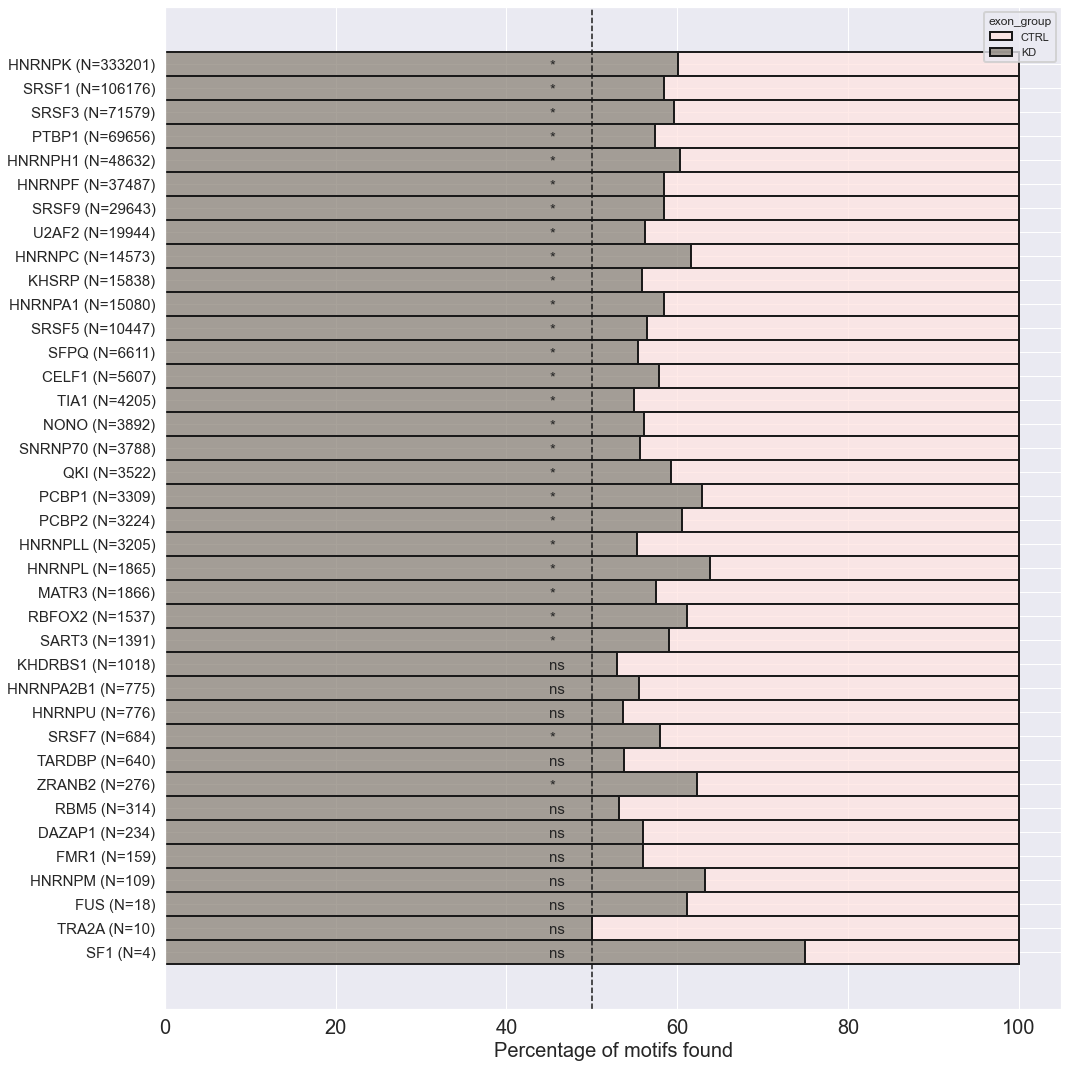

In [363]:
# Plot motif occurrences per group
fig, ax = plt.subplots(figsize=(15, 15))
counts_per_rbp['exon_group'] = pd.Categorical(counts_per_rbp['exon_group'], ['CTRL','KD'])
plt.rcParams['patch.linewidth'] = 2
plt.rcParams['patch.edgecolor'] = 'k'
plt.rcParams["patch.force_edgecolor"] = True
ax = sns.histplot(counts_per_rbp, y='rbp_name_with_N', hue='exon_group', weights='percentage', palette=['#FFE4E1', '#8B8378'], multiple='stack', kde_kws=dict(edgecolor="k", linewidth=2)) 

ax.axvline(50, color='k', ls='--')

i=0
for name, group in counts_per_rbp.groupby('rbp_name_with_N', sort=False):

    is_sign = group.iloc[0].is_sign
    ax.text(45, i + 0.25, is_sign, fontdict=dict(fontsize=15))
    i += 1
    
plt.rc('xtick', labelsize=20)   
plt.rc('ytick', labelsize=15)
plt.xlabel('Percentage of motifs found', size=20)
plt.ylabel('')
plt.tight_layout()
plt.savefig('/Users/pbarbosa/Desktop/motif_counts_per_group.pdf')

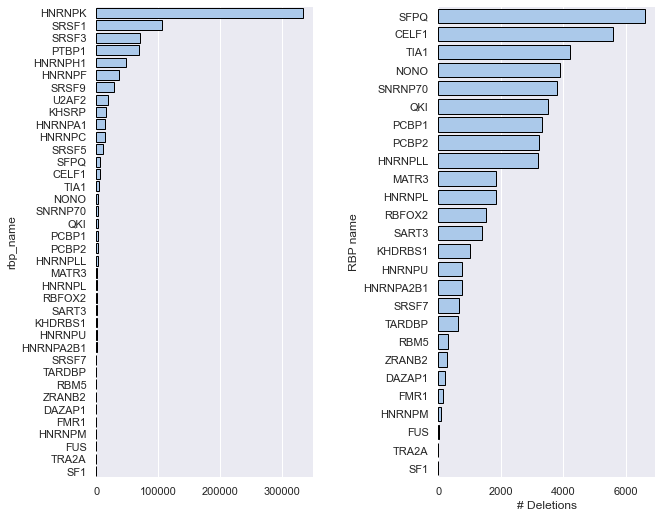

In [235]:
# Total motif counts, regardless of exon group

# Stacked horizontal barplot
counts_per_rbp = deletions.groupby('rbp_name').size().sort_values(ascending=False)

# Total counts per RBP
sns.set(font_scale = 1)
sns.set_color_codes("pastel")
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
sns.barplot(x=counts_per_rbp.values, y=counts_per_rbp.index,
            orient='h', color="b", order=counts_per_rbp.index, linewidth=1, edgecolor='black', ax=axes[0])
sns.despine(left=True, bottom=True)
plt.xlabel('# Deletions')
plt.ylabel('RBP name')
plt.rc('xtick', labelsize=14)   
plt.rc('ytick', labelsize=12) 
plt.rc('axes', labelsize=15)


counts_per_rbp2 = counts_per_rbp[counts_per_rbp < 10000]
ax2 = sns.barplot(x=counts_per_rbp2.values, y=counts_per_rbp2.index,
                  orient='h', color="b", order=counts_per_rbp2.index, linewidth=1, edgecolor='black', ax=axes[1])
ax2 = sns.despine(left=True, bottom=True)
plt.xlabel('# Deletions')
plt.ylabel('RBP name')
plt.rc('xtick', labelsize=14)   
plt.rc('ytick', labelsize=12) 
plt.rc('axes', labelsize=15)

f.tight_layout(pad=3.0)
plt.savefig('motif_counts.pdf')

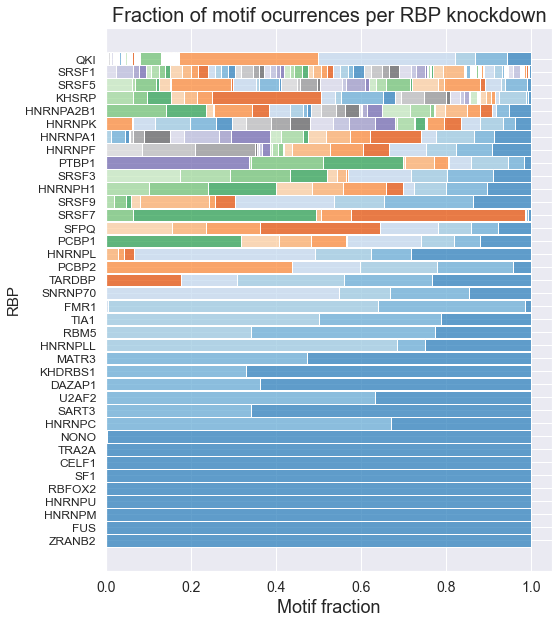

In [236]:
## Fraction of motifs per RBP plot, regardess of exon group

# Get fraction of motif ocurrence per RBP
f, ax3 = plt.subplots(figsize=(8, 10))
pct_per_rbp = deletions.groupby(['rbp_name', 'mutation']).size() / deletions.groupby('rbp_name').size()
df_pct = pd.DataFrame(pct_per_rbp, columns=['pct']).reset_index()

df_pct['Motif ID'] = df_pct.groupby('rbp_name').cumcount()+1
df_pct['RBP'] = pd.Categorical(df_pct['rbp_name'], list(df_pct.groupby('rbp_name').size().sort_values(ascending=False).index))
ax3 = sns.histplot(df_pct, y='RBP', hue='Motif ID', weights='pct', palette='tab20c', multiple='stack', shrink=0.99, kde_kws=dict(linewidth=0.2, edgecolor='black')) 
ax3.get_legend().remove()
ax3.set_xlabel('Motif fraction', fontsize=18)
ax3.set_title('Fraction of motif ocurrences per RBP knockdown', fontsize=20)
plt.savefig('motif_fraction.pdf')

LinAlgError: singular matrix

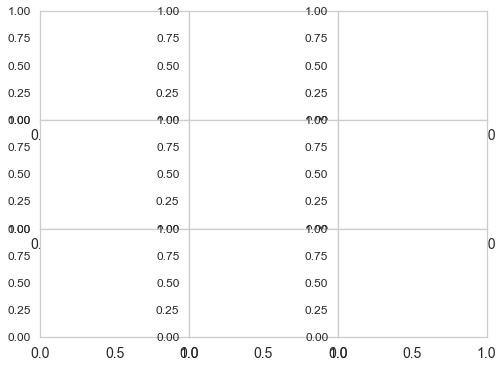

In [30]:
# Correlation between some properties

# Motif length
df_pct['motif_len']  = df_pct.mutation.str.len()
avg_motif_len = df_pct.groupby('rbp_name').motif_len.mean().to_frame('Avg Motif Len')

# Number of motifs per RBP
n_motifs_per_rbp = df_pct.groupby('rbp_name').size().to_frame('# Motifs/RBP')
cts_per_rbp = counts_per_rbp.to_frame('# Per RBP')

stats = avg_motif_len.merge(n_motifs_per_rbp, on='rbp_name').merge(cts_per_rbp, on='rbp_name')

sns.set_style("whitegrid", {'axes.grid' : False})
sm = pd.plotting.scatter_matrix(stats, s=200, linewidth=2, c='brown', alpha=0.5, figsize=(8, 6), diagonal='kde')
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
[s.get_yaxis().set_label_coords(-0.75,0.5) for s in sm.reshape(-1)]
[s.get_xaxis().set_label_coords(0.5,-0.5) for s in sm.reshape(-1)]
for i in range(np.shape(sm)[0]):
    for j in range(np.shape(sm)[1]):
        if i < j:
            sm[i,j].set_visible(False)
            
corr = stats.corr(method='spearman').values
pval = stats.corr(method=lambda x, y: scipy.stats.spearmanr(x, y)[1]) - np.eye(*corr.shape)

for i, j in zip(*plt.np.tril_indices_from(sm, k=1)):
    sm[i, j].annotate("{:.2f}\n (pval {:.4f})".format(corr[i, j], pval.iloc[i, j]), (0.7, 0.8), xycoords='axes fraction', ha='center', va='center')
    sm[i, j].tick_params(axis='x', labelsize=10, rotation=45)
    sm[i, j].tick_params(axis='y', labelsize=10)
#plt.show()
plt.tight_layout()
plt.savefig('motif_fraction.pdf')

In [31]:
any_effect = deletions.query('abs(Acceptor_Upstream_effect) >= 0.2 or abs(Donor_Upstream_effect) >= 0.2 or \
                              abs(Acceptor_Cassette_effect) >= 0.2 or abs(Donor_Cassette_effect) >= 0.2 or \
                              abs(Acceptor_Downstream_effect) >= 0.2 or abs(Donor_Downstream_effect) >= 0.2 or \
                              Other_Acceptor_effect == Other_Acceptor_effect or \
                              Other_Donor_effect == Other_Donor_effect')

upstream_effect = deletions.query('abs(Acceptor_Upstream_effect) >= 0.2 or abs(Donor_Upstream_effect) >= 0.2')
ups_effect_pos = deletions.query('Acceptor_Upstream_effect >= 0.2 or Donor_Upstream_effect >= 0.2')
ups_effect_neg = deletions.query('Acceptor_Upstream_effect <= -0.2 or Donor_Upstream_effect <= -0.2')

cassette_effect = deletions.query('abs(Acceptor_Cassette_effect) >= 0.2 or abs(Donor_Cassette_effect) >= 0.2')
cass_effect_pos = deletions.query('Acceptor_Cassette_effect >= 0.2 or Donor_Cassette_effect >= 0.2')
cass_effect_neg = deletions.query('Acceptor_Cassette_effect <= -0.2 or Donor_Cassette_effect <= -0.2')

downstream_effect = deletions.query('abs(Acceptor_Downstream_effect) >= 0.2 or abs(Donor_Downstream_effect) >= 0.2')
down_effect_pos = deletions.query('Acceptor_Downstream_effect >= 0.2 or Donor_Downstream_effect >= 0.2')
down_effect_neg = deletions.query('Acceptor_Downstream_effect <= -0.2 or Donor_Downstream_effect <= -0.2')

other_effect = deletions[(~deletions.Other_Acceptor_effect.isna()) |
                         (~deletions.Other_Donor_effect.isna()) ]

In [32]:
# Any effect
any_pct = any_effect.groupby('rbp_name').size() / deletions.groupby('rbp_name').size() * 100
upstream_pct = upstream_effect.groupby('rbp_name').size() / deletions.groupby('rbp_name').size() * 100
cassette_pct = cassette_effect.groupby('rbp_name').size() / deletions.groupby('rbp_name').size() * 100
downstream_pct = downstream_effect.groupby('rbp_name').size() / deletions.groupby('rbp_name').size() * 100
other_pct = other_effect.groupby('rbp_name').size() / deletions.groupby('rbp_name').size() * 100

list_dfs = [any_pct, upstream_pct, cassette_pct, downstream_pct, other_pct]
pct_df = pd.concat(list_dfs, axis=1)
pct_df.columns = ['Any diff', 'Upstream diff', 'Cassette diff', 'Downstream diff', 'Other diff']
pct_df = pct_df.fillna(0)

# Pos and Neg effects
upstream_pos_pct = ups_effect_pos.groupby('rbp_name').size() / deletions.groupby('rbp_name').size() * 100
upstream_neg_pct = ups_effect_neg.groupby('rbp_name').size() / deletions.groupby('rbp_name').size() * 100
cassette_pos_pct = cass_effect_pos.groupby('rbp_name').size() / deletions.groupby('rbp_name').size() * 100
cassette_neg_pct = cass_effect_neg.groupby('rbp_name').size() / deletions.groupby('rbp_name').size() * 100
downstream_pos_pct = down_effect_pos.groupby('rbp_name').size() / deletions.groupby('rbp_name').size() * 100
downstream_neg_pct = down_effect_neg.groupby('rbp_name').size() / deletions.groupby('rbp_name').size() * 100

list_dfs_pos_neg = [upstream_pos_pct, upstream_neg_pct, cassette_pos_pct, cassette_neg_pct, downstream_pos_pct, downstream_neg_pct]
pct_df_pos_neg = pd.concat(list_dfs_pos_neg, axis=1)
pct_df_pos_neg.columns = ['+ Upstream diff', '- Upstream diff', '+ Cassette diff', '- Cassette diff', '+ Downstream diff', '- Donwstream diff']
pct_df_pos_neg = pct_df_pos_neg.fillna(0)


ValueError: The condensed distance matrix must contain only finite values.

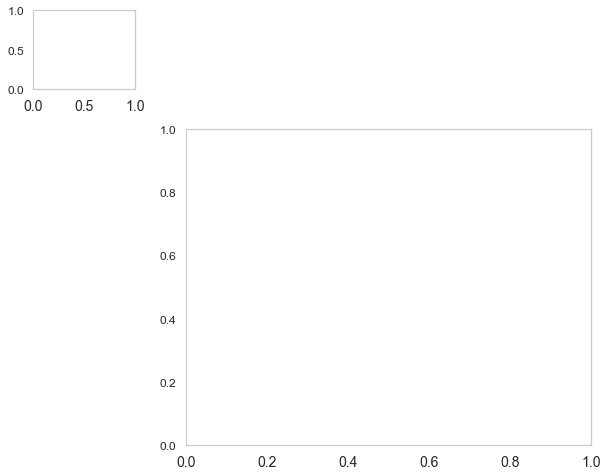

In [33]:
# Overall effects
h = sns.clustermap(pct_df.loc[~(pct_df==0).all(axis=1)].drop('Any diff', axis=1), 
              z_score=0,linecolor='black',linewidths=0.01, figsize=(10,8), annot=False, yticklabels=True)
h.ax_heatmap.set_ylabel("")
h.ax_heatmap.set_xticklabels(h.ax_heatmap.get_xmajorticklabels(), fontsize = 16)
plt.savefig('overall_effects.pdf')

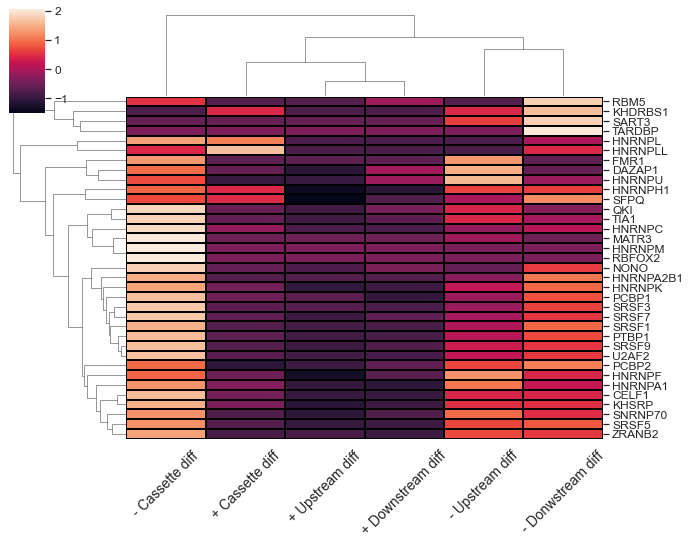

In [12]:
# Specific effects
h = sns.clustermap(pct_df_pos_neg.loc[~(pct_df_pos_neg==0).all(axis=1)], 
              z_score=0,linecolor='black',linewidths=0.01, figsize=(10,8), annot=False, yticklabels=True)
h.ax_heatmap.set_ylabel("")
h.ax_heatmap.set_xticklabels(h.ax_heatmap.get_xmajorticklabels(), rotation=45, fontsize = 14)
plt.savefig('overall_with_directionality_effects.pdf')

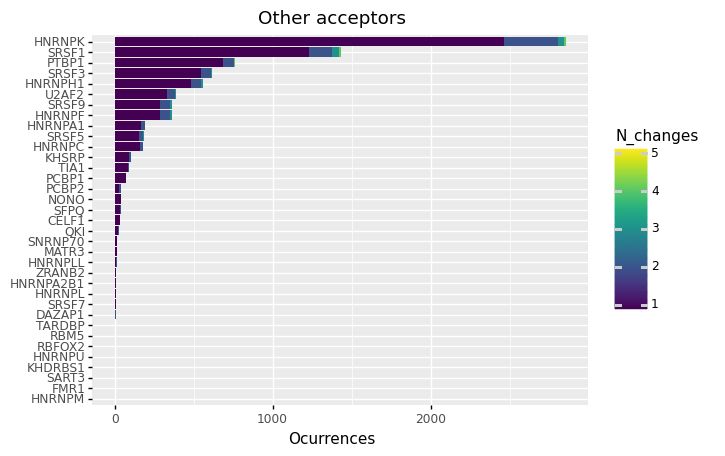

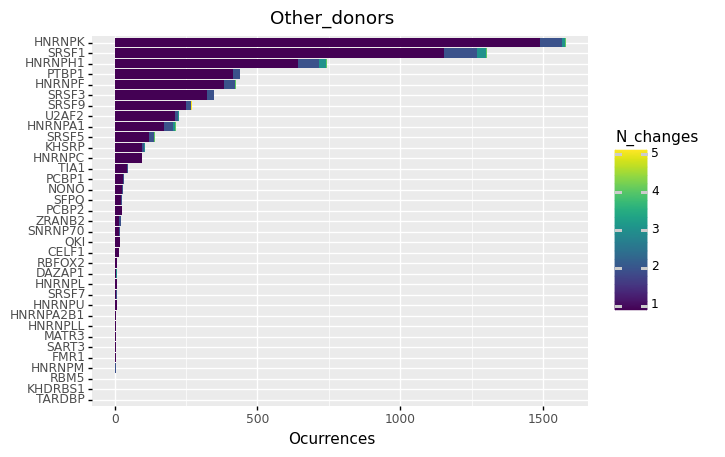

In [13]:
# Explode other change so that one per row is presented
_other_effect = other_effect.copy()
donor_cols = ['Other_Donor_effect', 'Other_Donor_distance_to_mutation', 'Other_Donor_position']
acceptor_cols = ['Other_Acceptor_effect', 'Other_Acceptor_distance_to_mutation', 'Other_Acceptor_position']
_other_effect[donor_cols + acceptor_cols] = _other_effect[donor_cols + acceptor_cols].apply(lambda x: x.str.split(";"))

exploded_d = _other_effect.explode(donor_cols).dropna(subset=donor_cols)
exploded_a = _other_effect.explode(acceptor_cols).dropna(subset=acceptor_cols)

# Count ocurrences of changes in other positions, per sequence and per RBP basis
def count_n_times(df: pd.DataFrame):
    """
    Counts the number of times that a single 
    mutation alters spliceAI predictions in 
    other positions of the input sequence
    """

    return df.groupby('id').size().value_counts().rename_axis('N_changes').reset_index(name='Ocurrences')

for i, df in enumerate([exploded_a, exploded_d]):
    n_other_changes_per_seq = df.groupby(['rbp_name']).apply(lambda x: count_n_times(x)).reset_index().drop('level_1', axis=1)
    categories = n_other_changes_per_seq.groupby('rbp_name')['Ocurrences'].sum().sort_values(ascending=False).index.tolist()[::-1]
    n_other_changes_per_seq['rbp_name'] = pd.Categorical(n_other_changes_per_seq['rbp_name'], categories=categories, ordered=False)

    if i == 0:
        title='Other acceptors'
    else:
        title="Other_donors"
      
    gg = (ggplot(n_other_changes_per_seq, aes('rbp_name', 'Ocurrences', fill='N_changes')) + 
    geom_col() + coord_flip() + xlab('') + 
    labs(title=title))
    gg.draw()
    


array([<AxesSubplot:ylabel='Frequency'>], dtype=object)

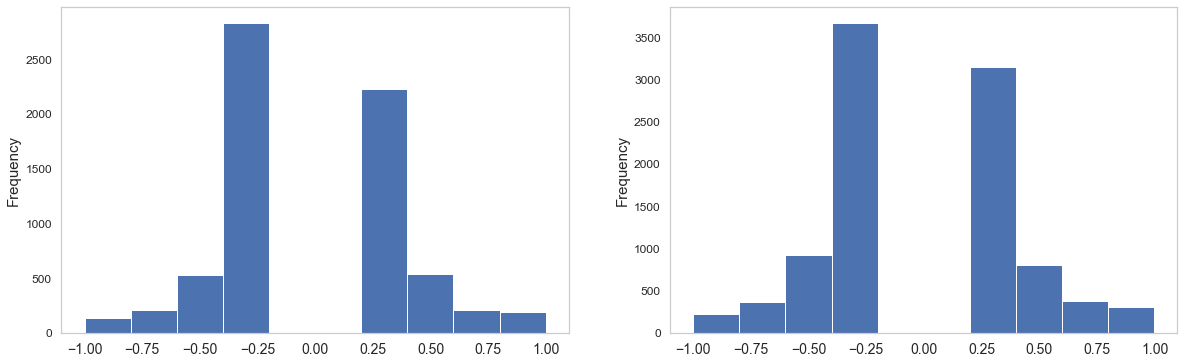

In [14]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(20, 6))

exploded_d['Other_Donor_effect'] = exploded_d['Other_Donor_effect'].astype(float)
exploded_d['Other_Donor_effect'].plot(kind='hist', ax= axes[0], subplots=True)

exploded_a['Other_Acceptor_effect'] = exploded_a['Other_Acceptor_effect'].astype(float)
exploded_a['Other_Acceptor_effect'].plot(kind='hist', ax= axes[1], subplots=True)

## Cassette exon analysis

### Each exon group

In [242]:
cass = deletions.copy()
cass = cass[cass.exon_group == "KD"]

In [243]:
donor_col = 'Donor_Cassette_effect'
acceptor_col = 'Acceptor_Cassette_effect'
cass['mutation_effect'] = cass[[donor_col, acceptor_col]].mean(axis=1)
cass['cass_diff'] = cass[[donor_col, acceptor_col]].abs().gt(0.1).any(1)

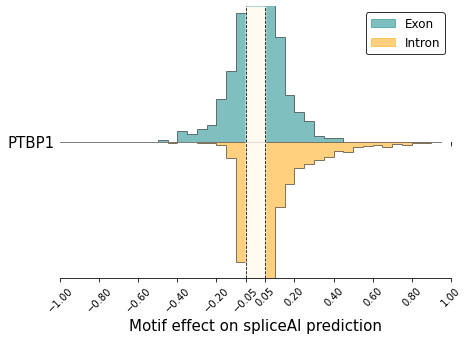

In [244]:
import matplotlib.patches as mpatches
cass_filt = cass.copy()

# Change signed values to represent effect of motifs in spliceAI preds
cass_filt['mutation_effect'] = cass_filt.mutation_effect * (-1)

rbps = ['HNRNPA1','HNRNPC','HNRNPF','HNRNPH1','HNRNPK', 'U2AF2', 'PTBP1','SRSF1','SRSF3','SRSF5','SRSF9']
rbp = 'PTBP1'
cass_filt=cass_filt[cass_filt.rbp_name == rbp]
cass_filt.Is_in_exon = cass.Is_in_exon.replace({True: 'Exon', False: 'Intron'})
cass_filt = cass_filt.rename(columns={'Is_in_exon': 'Location of motif'})

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(7, 5))

bins = np.arange(-1,1, 0.05)
for ax, location, color, invert in zip(axes.ravel(), ['Exon', 'Intron'], ['teal', 'orange'], [False,True]):
    values=cass_filt[cass_filt['Location of motif'] == location].mutation_effect
    _ylim=len(values[values > 0.05]) * 0.35
    
    kwargs = dict(histtype='stepfilled', alpha=0.5, density=False, ec="k")
    ax.hist(values, bins=bins, color=color, **kwargs)
    
    ax.set_ylim(0, _ylim)
    ax.set_xlim(-1, 1)
    ax.axvline(-0.05, color='k', linewidth=0.8, ls='--')
    ax.axvline(0.05, color='k', linewidth=0.8, ls='--')
    ax.set_yticks([])
    y = np.arange(0, _ylim,0.1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.fill_betweenx(y, -0.05, 0.05, color='floralwhite', alpha=1)
    if invert:
        ax.invert_yaxis()
        ax.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, -0.05, 0.05, 0.2, 0.4, 0.6, 0.8, 1])    
        ax.tick_params(axis='x', labelsize=10, rotation=45)
    else:
        exon_patch = mpatches.Patch(color='teal', alpha=0.5, label='Exon')
        intron_patch = mpatches.Patch(color='orange', alpha=0.5, label='Intron')
        legend = ax.legend(handles=[exon_patch, intron_patch], edgecolor='k', prop={'size': 12})

   
fig.supylabel(rbp, rotation=0, size=15)
plt.subplots_adjust(hspace=0)
plt.xlabel('Motif effect on spliceAI prediction', size=15)

plt.savefig('/Users/pbarbosa/Desktop/{}.pdf'.format(rbp), bbox_inches = "tight")

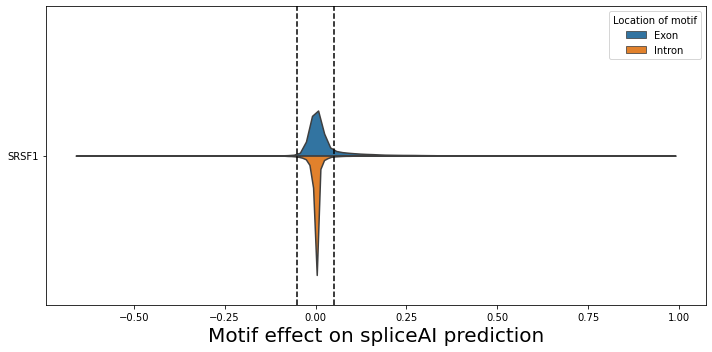

In [45]:
# Plot only relevant changes
cass_filt = cass[(cass.mutation_effect <= -0.05) | (cass.mutation_effect >= 0.05)]
cass_filt = cass.copy()

# Change signed values to represent effect of motifs in spliceAI preds
cass_filt['mutation_effect'] = cass_filt.mutation_effect * (-1)

cass_filt=cass_filt[cass_filt.rbp_name == "SRSF1"]
cass_filt.Is_in_exon = cass.Is_in_exon.replace({True: 'Exon', False: 'Intron'})
cass_filt = cass_filt.rename(columns={'Is_in_exon': 'Location of motif'})


fig, ax = plt.subplots(figsize=(10, 5))
#palette={'KD': 'burlywood', 'CTR6': 'gray'}
ax = sns.violinplot(data=cass_filt,
               x='mutation_effect',
               y='rbp_name', 
               hue='Location of motif',
               split=True, 
 #              palette=palette,
               #scale='area', 
               #scale_hue=True,
               orient='h',
               inner=None)

ax.axvline(-0.05, color='k', ls='--')
ax.axvline(0.05, color='k', ls='--')
plt.xlabel('Motif effect on spliceAI prediction', size=20)
plt.ylabel('')
plt.tight_layout()
plt.savefig('/Users/pbarbosa/Desktop/all_datapoints_KD.pdf')


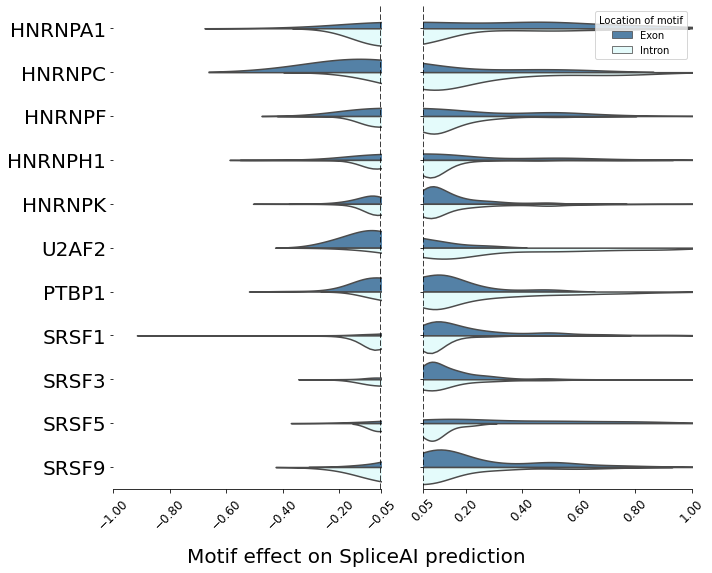

In [77]:
cass_filt = cass.copy()

cass_filt.Is_in_exon = cass.Is_in_exon.replace({True: 'Exon', False: 'Intron'})
cass_filt = cass_filt.rename(columns={'Is_in_exon': 'Location of motif'})

# Change signed values to represent effect of motifs in spliceAI preds
cass_filt['mutation_effect'] = cass_filt.mutation_effect * (-1) 
cass_filt = cass_filt[(cass_filt.mutation_effect <= -0.05) | (cass_filt.mutation_effect >= 0.05)]

#cass_filt=cass_filt[cass_filt.rbp_name == "SRSF1"]
rbps = ['HNRNPA1','HNRNPC','HNRNPF','HNRNPH1','HNRNPK', 'U2AF2', 'PTBP1','SRSF1','SRSF3','SRSF5','SRSF9']

cass_filt = cass_filt[cass_filt.rbp_name.isin(rbps)]
cass_filt['rbp_name'] = pd.Categorical(cass_filt.rbp_name, categories=rbps)

cass_filt['Location of motif'] = pd.Categorical(cass_filt['Location of motif'], categories=['Exon', 'Intron'])
palette={'Exon': 'steelblue', 'Intron': 'lightcyan'}
f, (ax1, ax2) = plt.subplots(figsize=(10, 8), ncols=2, nrows=1, sharey=True)
ax1 = sns.violinplot(x="mutation_effect", y="rbp_name", hue="Location of motif", palette=palette, inner=None, split=True, data=cass_filt, ax=ax1)
ax2 = sns.violinplot(x="mutation_effect", y="rbp_name", hue="Location of motif", palette=palette, inner=None, split=True, data=cass_filt, ax=ax2)
 
ax1.set_xlim(-1,-0.05)
ax2.set_xlim(0.05,1)  

sns.despine(ax=ax1, left=True)
sns.despine(ax=ax2, left=True)

#ax1.spines['right'].set_visible(False)
#ax2.spines['left'].set_visible(False)
#ax1.yaxis.tick_left()
#ax1.tick_params(labeltop='off') # don't put tick labels at the top
#ax2.yaxis.tick_right()

plt.subplots_adjust(wspace=0.01)
# d = 0.001  # how big to make the diagonal lines in axes coordinates
# # arguments to pass to plot, just so we don't keep repeating them
# kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
# ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.set_xlabel('')
ax1.set_ylabel('')

# ax2 = ax_right
ax2.set_xlabel('')
ax2.set_ylabel('')

# #remove one of the legend
ax1.legend_.remove()
ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, -0.05])
ax1.tick_params(axis='x', labelsize=12, rotation=45)
ax1.tick_params(axis='y', labelsize=20)

ax1.axvline(-0.05, color='k', ls='--')
ax2.axvline(0.05, color='k', ls='--')
ax2.set_xticks([0.05, 0.2, 0.4, 0.6, 0.8, 1])
ax2.tick_params(axis='x', labelsize=12, rotation=45)
f.supxlabel('Motif effect on SpliceAI prediction', size=20)
plt.tight_layout()
plt.savefig('/Users/pbarbosa/Desktop/big_effects_datapoints_CTRL.pdf')
plt.show()

In [108]:
#Year,Number of publications
#2013,1520
#2014,1940
#2015,2640
#2016,4340
#2017,7630
#2018,14000
#2019,22600
#2020,33100
#2021,36600
 
df = pd.read_csv('d.tsv')
df['Year'] = pd.Categorical(df.Year)

print(df)
p1 = (ggplot(df, aes(x='Year', y='Number of publications')) +
            geom_bar(stat='identity', fill='grey', color='black') + 
            scale_y_continuous(breaks = [0, 5000, 10000, 15000, 20000, 25000,30000,35000]) +
            ggtitle('"deep learning" AND "biology"'))
p1.save('/Users/pbarbosa/Desktop/publications.pdf')

   Year  Number of publications
0  2013                    1520
1  2014                    1940
2  2015                    2640
3  2016                    4340
4  2017                    7630
5  2018                   14000
6  2019                   22600
7  2020                   33100
8  2021                   36600


/Users/pbarbosa/miniconda3/envs/genomics/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/pbarbosa/miniconda3/envs/genomics/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/pbarbosa/Desktop/publications.pdf


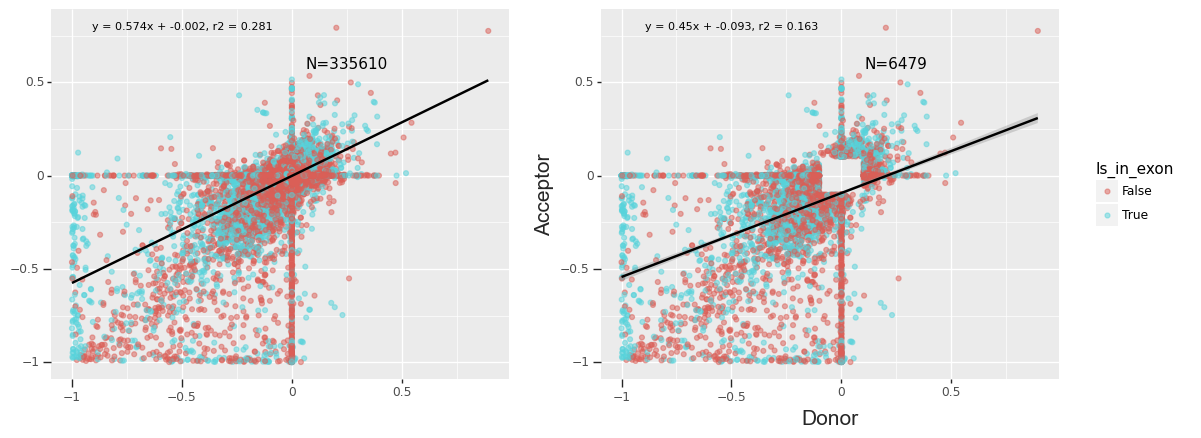

In [35]:
# Do linear regression to extract the statistics to annotate the plots
slope_a, intercept_a, rvalue_a, _, _ = scipy.stats.linregress(cass[donor_col], cass[acceptor_col])

# Create subplots using plotnine (one with all the data, other with a subset of it)
p1 = (ggplot(cass, aes(x=donor_col, y=acceptor_col)) +
        geom_point(aes(color='Is_in_exon'), alpha = 0.5) + 
        geom_smooth(se=True, method="lm", color="black") + 
        annotate("text", x = 0.25, y = 0.6, label = "N={}".format(cass.shape[0])) +
        xlab('Donor') +
        ylab('Acceptor') +
        annotate('text', x=-0.5, y = 0.8, size=8, label='y = {}x + {}, r2 = {}'.format(str(round(slope_a, 3)), str(round(intercept_a, 3)), str(round(rvalue_a ** 2, 3))))
)

cass = cass[cass.cass_diff]
slope_b, intercept_b, rvalue_b, _, _ = scipy.stats.linregress(cass[donor_col], cass[acceptor_col])

p2 = (ggplot(cass, aes(x=donor_col, y=acceptor_col)) +
        geom_point(aes(color='Is_in_exon'), alpha = 0.5) + 
        geom_smooth(se=True, method="lm", color="black") + 
        annotate("text", x = 0.25, y = 0.6, label = "N={}".format(cass.shape[0])) +
        annotate('text', x=-0.5, y = 0.8, size=8, label='y = {}x + {}, r2 = {}'.format(str(round(slope_b, 3)), str(round(intercept_b, 3)), str(round(rvalue_b ** 2, 3))))
)

# Empty plotnine figure to place the subplots on. Needs junk data (for backend "copy" reasons).
from plotnine import data

fig = (ggplot()+geom_blank(data=data.diamonds)+theme_void()).draw()

# Create gridspec for adding subpanels to the blank figure
gs = matplotlib.gridspec.GridSpec(1,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

# Add subplots to the figure
_ = p1._draw_using_figure(fig, [ax1])
_ = p2._draw_using_figure(fig, [ax2])

fig.set_figwidth(13)

plt.xlabel('Donor')
plt.ylabel('Acceptor')

/Users/pbarbosa/miniconda3/envs/genomics/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 16 x 13 in image.
/Users/pbarbosa/miniconda3/envs/genomics/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: per_rbp_cassette_effects.png
/Users/pbarbosa/miniconda3/envs/genomics/lib/python3.9/site-packages/plotnine/stats/stat_smooth.py:201: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
/Users/pbarbosa/miniconda3/envs/genomics/lib/python3.9/site-packages/plotnine/stats/stat_smooth.py:201: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.


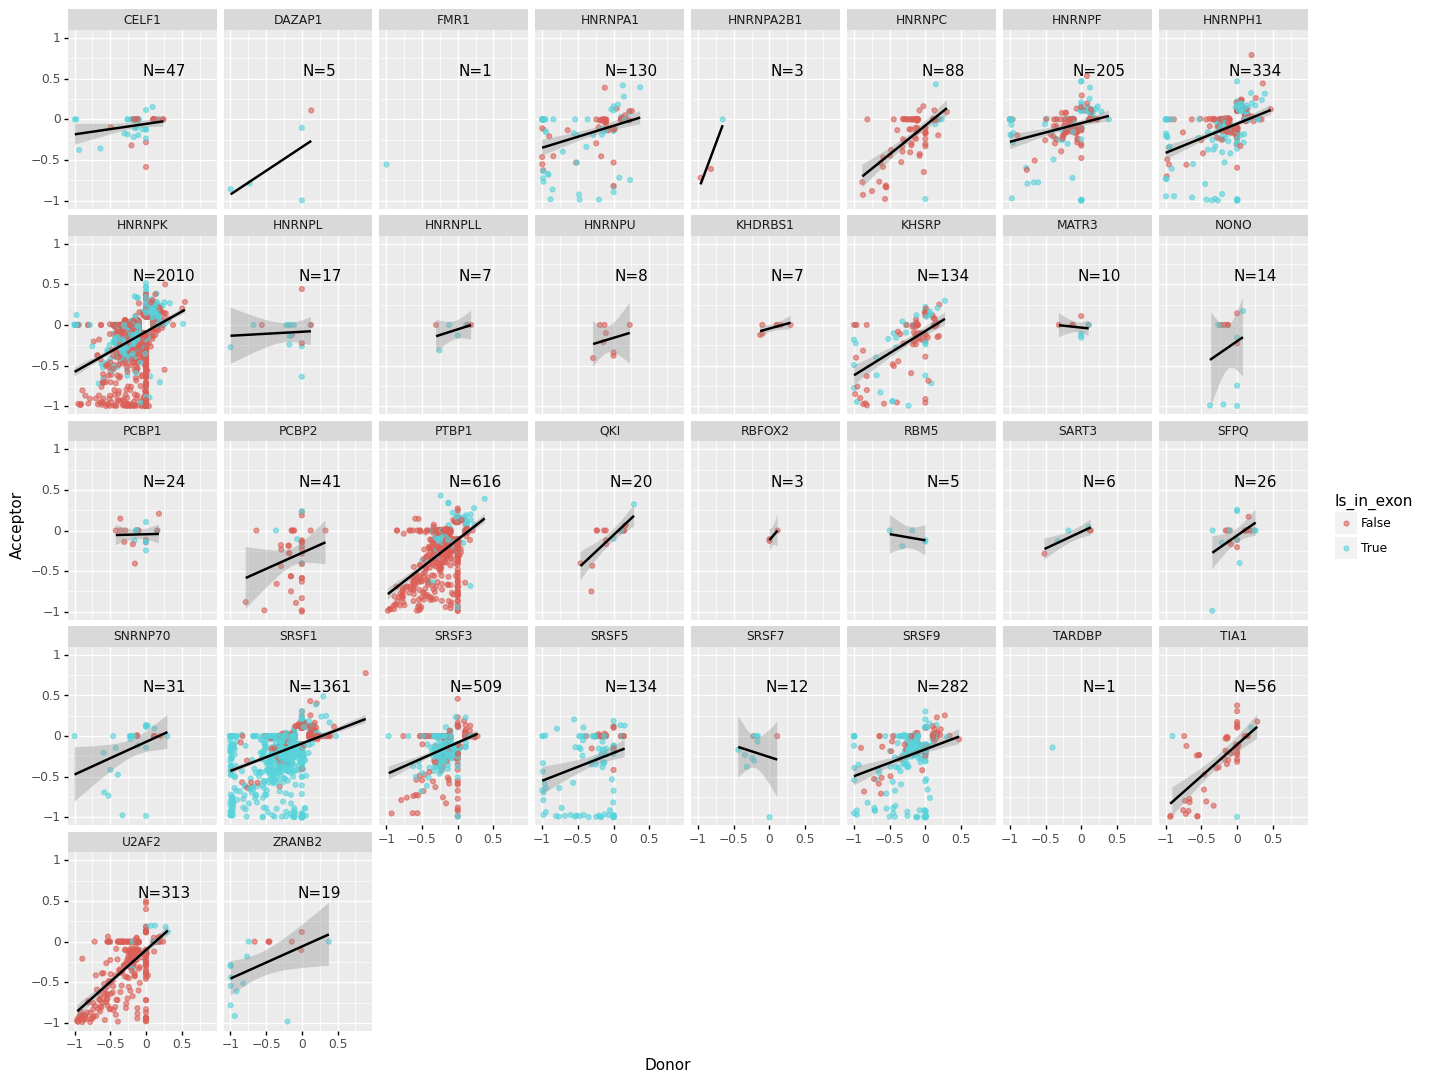

<ggplot: (8767863826104)>

In [85]:
cass = deletions.copy()
donor_col = 'Donor_Cassette_effect'
acceptor_col = 'Acceptor_Cassette_effect'

cass['cass_diff'] = cass[[donor_col, acceptor_col]].abs().gt(0.1).any(1)
mask = ~np.isnan(cass[acceptor_col]) & ~np.isnan(cass[donor_col])
cass = cass[mask]
cass = cass[cass.cass_diff]

N_df = cass.groupby('rbp_name').size().reset_index().rename({0: 'N'}, axis=1)
N_df['N'] = N_df.N.apply(lambda x: "N={}".format(str(x)))

p1 = (ggplot(cass, aes(x=donor_col, y=acceptor_col))
    + geom_point(aes(color='Is_in_exon'), alpha = 0.6)
    + geom_smooth(se=True, method="lm", color="black") 
    + facet_wrap('rbp_name', ncol=8)
    + geom_text(data = N_df, mapping=aes(label = 'N', x = 0.25, y = 0.6))
    + labs(x='Donor', y='Acceptor') 
    + ylim(-1, 1)
    + theme(figure_size=(16, 13))
)

p1.save('per_rbp_cassette_effects.png')
p1

In [215]:
effect_df_ = deletions.copy()
effect_df_['any_diff'] = effect_df_[effect_cols].abs().gt(0.2).any(1)
effect_df = effect_df_[effect_df_.any_diff][effect_cols + ['Location', 'Is_in_exon', 'rbp_name']]
effect_df.columns = [col.replace("_effect", "") for col in effect_df.columns] 
ordered_effects = ['Acceptor_Upstream', 'Donor_Upstream', 'Acceptor_Cassette', 'Donor_Cassette', 'Acceptor_Downstream', 'Donor_Downstream']

In [ ]:
# calculate the correlation matrix
corr = effect_df[ordered_effects].corr()
sns.set(font_scale = 1)
cm = sns.heatmap(corr, 
                 linecolor='black',
                 linewidths=0.1,
                 cbar=True,
                 annot=True,
                 xticklabels=1,
                 fmt='.2f',
                 cmap=sns.color_palette("Blues", as_cmap=True))
plt.tight_layout()
plt.savefig('effects_correlation.pdf')

### Compare mutation effects between groups

In [452]:
cass = deletions.copy()
donor_col = 'Donor_Cassette_effect'
acceptor_col = 'Acceptor_Cassette_effect'

cass['mutation_effect'] = cass[[donor_col, acceptor_col]].mean(axis=1)
#cass['mutation_effect'] = cass[[donor_col, acceptor_col]].abs().mean(axis=1)

# Count motif occurences per exon group
counts = cass.groupby(['rbp_name']).size().reset_index().rename(columns={0: 'c'})
counts['rbp_name_with_N'] = counts.rbp_name + " (N=" + counts.c.astype(str) + ")"

cass = pd.merge(cass, counts.drop('c', axis=1), on='rbp_name')
cass = cass[cass.groupby(['rbp_name_with_N'])['target_coordinates'].transform('count') > 100]


/Users/pbarbosa/miniconda3/envs/genomics/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


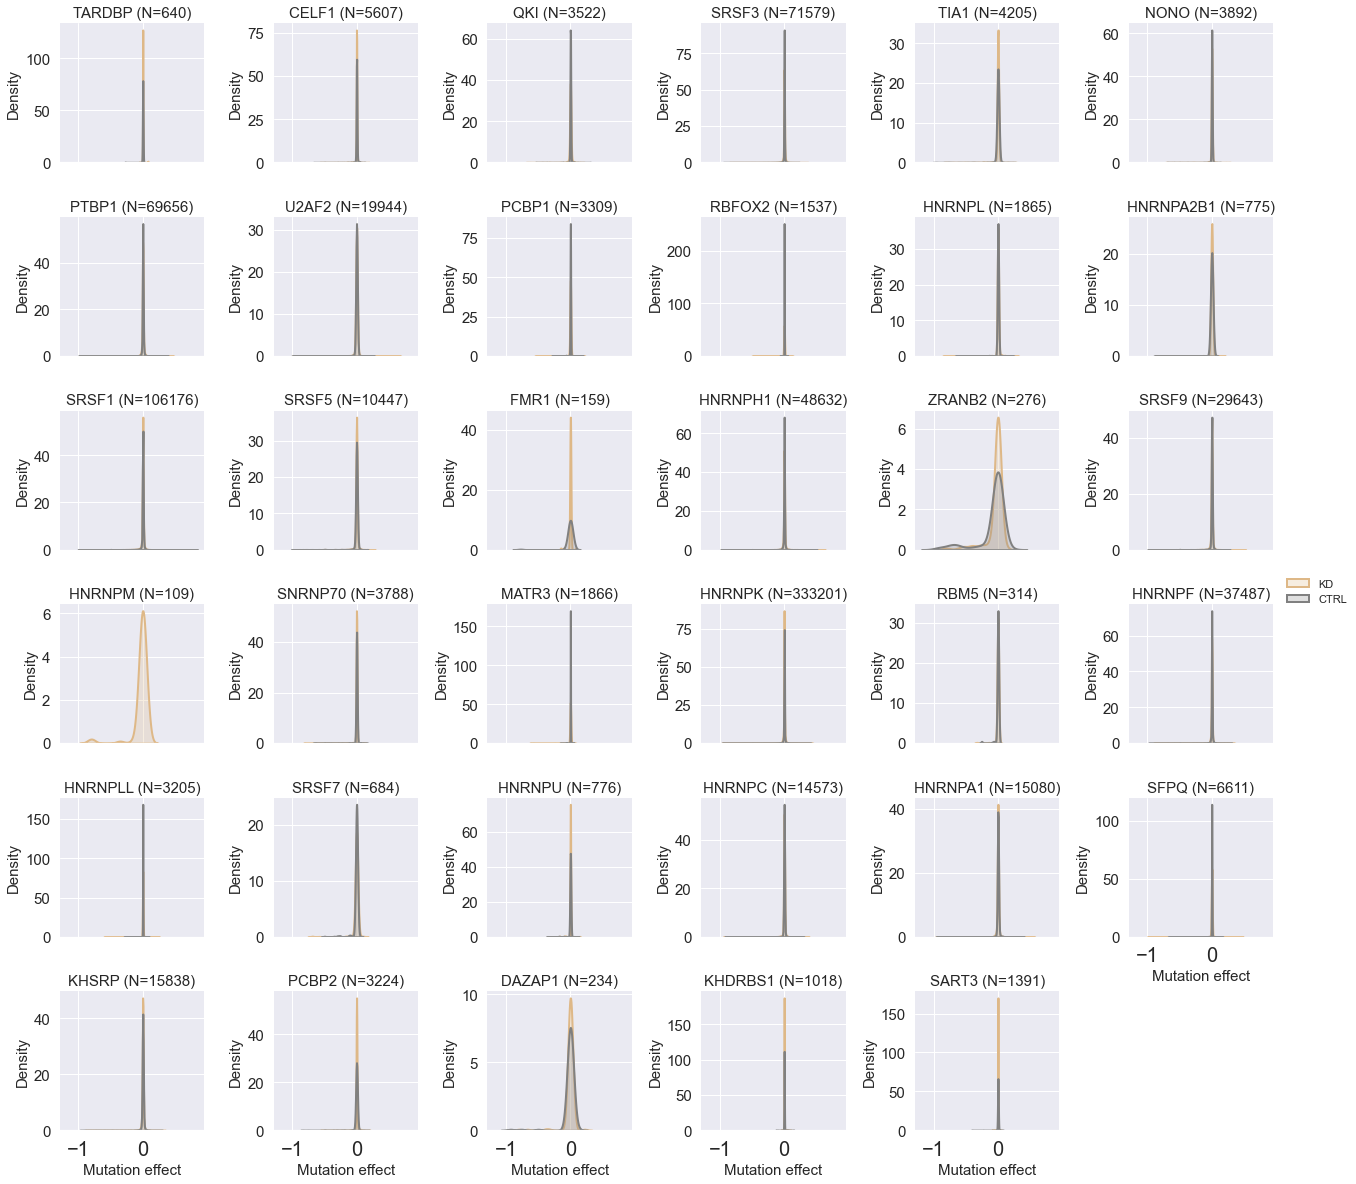

In [365]:
# Histogram per RBP
palette={'KD': 'burlywood', 'CTRL': 'gray'}
g = sns.FacetGrid(cass, col='rbp_name_with_N', col_wrap=6, hue='exon_group', palette=palette, sharey=False, sharex=True)
g= g.map(sns.kdeplot, 'mutation_effect', fill=True).add_legend(title="")
g.set_titles("{col_name}").despine(left=True)
g.fig.subplots_adjust(top=0.9)
#g.fig.savefig('4_features_discrimination_on_spliceAI_preds/{}_hist.pdf'.format(outname))
#plt.close()

/var/folders/b3/gm46dbjx163242n1pr2792n40000gq/T/ipykernel_1095/2190426524.py:13: FutureWarning: Passing 'suffixes' which cause duplicate columns {'is_sign_x'} in the result is deprecated and will raise a MergeError in a future version.


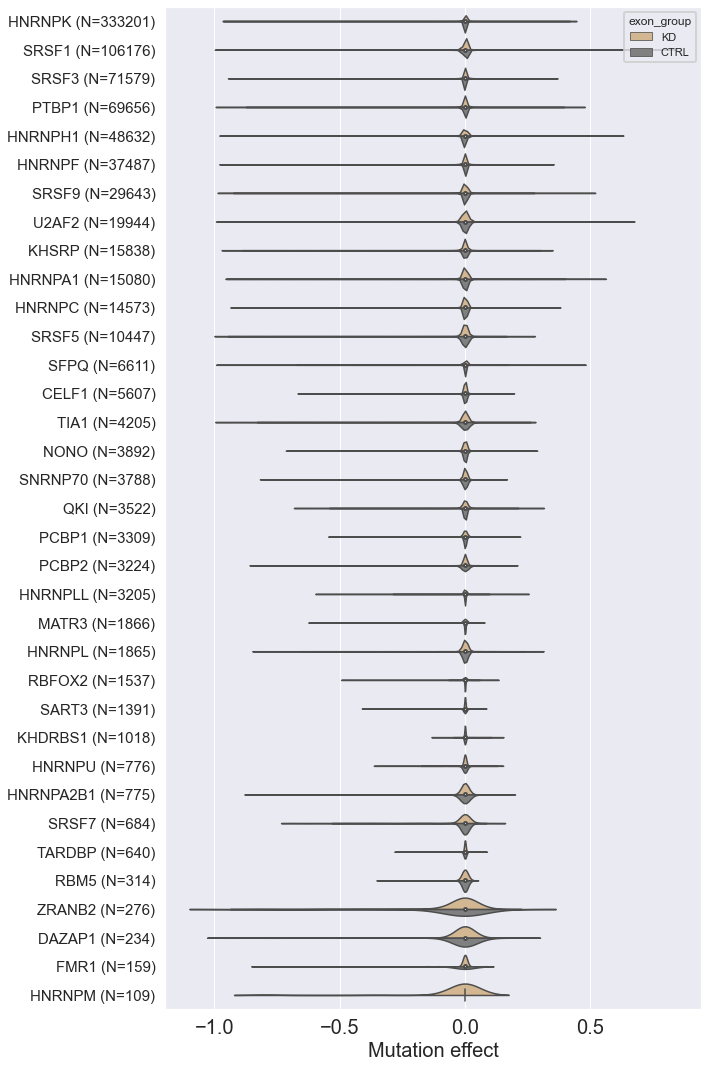

In [377]:
# Welch tests
import statsmodels
from scipy.stats import mannwhitneyu, ttest_ind

pvals = cass.groupby('rbp_name_with_N').apply(lambda x: ttest_ind(x[x.exon_group == "CTRL"]['mutation_effect'],
                                                                  x[x.exon_group == "KD"]['mutation_effect'], 
                                                                  equal_var=False).pvalue)

pval_corrected = statsmodels.stats.multitest.multipletests(pvals, alpha=0.05, method='holm', is_sorted=False, returnsorted=False)[0]


is_sign_df = pd.DataFrame({'rbp_name_with_N': pvals.index, 'is_sign': pval_corrected}).replace({True: "*", False: 'ns'})
cass = pd.merge(cass, is_sign_df, on='rbp_name_with_N')

#########################
fig, ax = plt.subplots(figsize=(10, 15))
palette={'KD': 'burlywood', 'CTRL': 'gray'}

# Sort RBPs by the number of motifs
cass['rbp_name_with_N'] = pd.Categorical(cass.rbp_name_with_N, 
                                         categories=cass.groupby('rbp_name_with_N').size().sort_values(ascending=False).index, 
                                         ordered=True)

ax = sns.violinplot(data=cass,
               y='rbp_name_with_N',
               x='mutation_effect', 
               hue='exon_group',
               dodge=False, 
               split=True, 
               orient='h',
               palette=palette,
               #scale='area', 
               #scale_hue=True,
               inner='box')

# Add statistical sign to the figure
# pos = range(is_sign_df.shape[0])
# for tick, label in zip(pos, ax.get_yticklabels()):
#     ax.text(1, 
#             pos[tick],
#             is_sign_df[is_sign_df.rbp_name_with_N == label.get_text()].iloc[0].is_sign,
#             horizontalalignment='center',
#             fontdict=dict(fontsize=15))

plt.xlabel('Mutation effect', size=20)
plt.ylabel('')
plt.tight_layout()
plt.savefig('perRBP_effects_dist.pdf')

Text(0, 0.5, '')

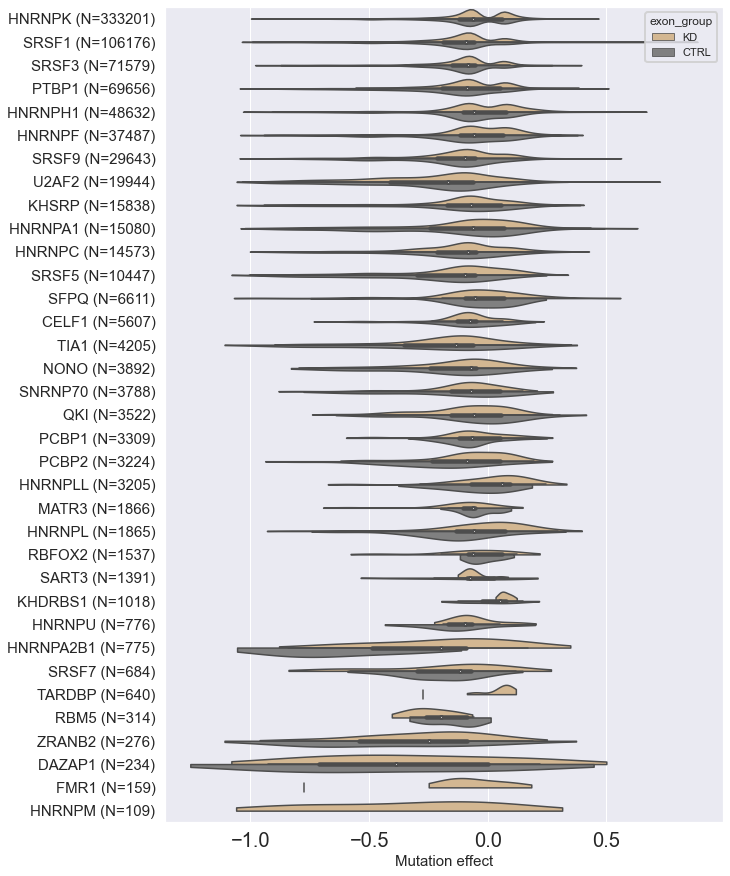

In [376]:
fig, ax = plt.subplots(figsize=(10, 15))
palette={'KD': 'burlywood', 'CTRL': 'gray'}
sns.violinplot(data=cass[(cass['mutation_effect'] <= -0.05) | (cass['mutation_effect'] >= 0.05)],
               y='rbp_name_with_N',
               x='mutation_effect', 
               hue='exon_group',
               dodge=False, 
               split=True, 
               orient='h',
               palette=palette,
               #scale='area', 
               #scale_hue=True,
               inner='box')

plt.ylabel('')

In [ ]:
cass['mutation_effect'] = cass['mutation_effect'].abs()
cass_5pct = cass.query('mutation_effect >= 0.05')
cass_10pct = cass.query('mutation_effect >= 0.1')
cass_15pct = cass.query('mutation_effect >= 0.15')
cass_20pct = cass.query('mutation_effect >= 0.2')


cass_5pct = cass_5pct.groupby(['rbp_name', 'exon_group']).size() / cass.groupby(['rbp_name', 'exon_group']).size() * 100
cass_5pct = cass_5pct.reset_index().rename(columns={0: 'frac'})
cass_5pct['thresh'] = '>5%'

cass_10pct = cass_10pct.groupby(['rbp_name', 'exon_group']).size() / cass.groupby(['rbp_name', 'exon_group']).size() * 100
cass_10pct = cass_10pct.reset_index().rename(columns={0: 'frac'})
cass_10pct['thresh'] = '>10%'

cass_15pct = cass_15pct.groupby(['rbp_name', 'exon_group']).size() / cass.groupby(['rbp_name', 'exon_group']).size() * 100
cass_15pct = cass_15pct.reset_index().rename(columns={0: 'frac'})
cass_15pct['thresh'] = '>15%'

cass_20pct = cass_20pct.groupby(['rbp_name', 'exon_group']).size() / cass.groupby(['rbp_name', 'exon_group']).size() * 100
cass_20pct = cass_20pct.reset_index().rename(columns={0: 'frac'})
cass_20pct['thresh'] = '>20%'

rbps = ['HNRNPA1','HNRNPC','HNRNPF','HNRNPH1','HNRNPK','PTBP1','SRSF1','SRSF3','SRSF5','SRSF9','U2AF2']


list_dfs = [cass_5pct, cass_10pct,
            cass_15pct, cass_20pct]

pct_df = pd.concat(list_dfs)
pct_df = pct_df[pct_df.rbp_name.isin(rbps)]

# Plot at different thresholds
# g = sns.catplot( data=pct_df, kind="bar", col='rbp_name', col_wrap=6, sharey=False,
#                 x="thresh", y="frac", hue="exon_group", palette="dark", alpha=.6, height=6
# )

# g.set_titles("{col_name}").despine(left=True)
# g.set_axis_labels("Magnitude of effect", "% of mutations with effect")
# g.legend.set_title("")

# Plot just a single threshold

palette={'KD': 'burlywood', 'CTRL': 'gray'}
pct_df = pct_df[pct_df.thresh == ">5%"]

ax = sns.catplot(data=pct_df, kind="bar",
                x="frac", y="rbp_name", hue="exon_group", palette=palette, alpha=.8, height=8, aspect=1
)

ax.set_titles("{col_name}").despine(left=True)
ax.set_axis_labels("% of mutations with meaningful effect", "")
ax.legend.set_title("")
#plt.savefig('/Users/pbarbosa/Desktop/not_simple.pdf')

### Correlation between RNA-Seq and SpliceAI 

In [38]:
# MAP OF SpliceAI IDs to original Exon Coordinates
spliceAI_Seqs_To_ExonCoords = pd.read_csv('/Users/pbarbosa/Desktop/NFS_Pedro/phd/rbp_data/HepG2/splicing_related/FINAL_RNA_SEQ_dPSIs_PER_SpliceAI_seq.tsv.gz', sep="\t").rename({'exon_coord': 'target_coordinates'}, axis=1)

In [39]:
_cass = cass[cass.cass_diff][['rbp_name', 'target_coordinates', 'Donor_Cassette_effect', 'Acceptor_Cassette_effect']]
_cass['pred_dPSI'] = np.mean(_cass[['Donor_Cassette_effect', 'Acceptor_Cassette_effect']], axis=1)

_cass['pred_dPSI'] = _cass[['Donor_Cassette_effect', 'Acceptor_Cassette_effect']].apply(lambda x: x[np.argmax(np.abs(x))], axis=1)

In [40]:
df = pd.merge(_cass, spliceAI_Seqs_To_ExonCoords, on=['target_coordinates', 'rbp_name'])

# When multiple mutsplice observations for a given exon, select the closest to the real dPSI
df = df.groupby(['rbp_name', 'target_coordinates', 'dPSI']).apply(lambda x: x.loc[(x.dPSI - x.pred_dPSI).abs().idxmin()]).reset_index(drop=True)

In [41]:
p2 = (ggplot(df, aes(x='dPSI', y='pred_dPSI')) +
        geom_point(alpha = 0.5)
)

In [ ]:
 p2 = (ggplot(df, aes(x='dPSI', y='pred_dPSI')) +
        geom_point(alpha = 0.5) + 
        #geom_smooth(se=True, method="lm", color="black") +
        facet_wrap('rbp_name', ncol=8) + 
        theme(figure_size=(16, 13)))

## Analysis based on location

### Using rows with any effect

In [216]:
effect_tidy = effect_df.melt(id_vars=['Location', 'Is_in_exon', 'rbp_name'], var_name='Effect', value_name='SpliceAI_diff')
effect_tidy_cass = effect_tidy[effect_tidy.Effect.str.contains('Cassette')]

In [ ]:
hue_order=['Intron_Upstream_2', 'Exon_upstream_acceptor_region', 'Exon_upstream_full_span', 'Exon_upstream_fully_contained', 'Exon_upstream_donor_region', 
           'Intron_Upstream', 'Exon_cassette_acceptor_region', 'Exon_cassette_fully_contained', 'Exon_cassette_donor_region', 'Intron_Downstream',
           'Exon_downstream_acceptor_region', 'Exon_downstream_fully_contained', 'Exon_downstream_donor_region', 'Intron_Downstream_2']
#fig, ax = plt.subplots(figsize=(18, 12))
#g = sns.factorplot("id","num_mutations",data=grouped_samples, order=id_list, kind="box", size=7, aspect=3, palette=organ_palette)
sns.set(font_scale = 4)
pallette=['dodgerblue4', 'deepskyblue2', 'darkslategray3', 'darkslategray1', 'darkslategray4', 
          'darkgoldenrod3', 'cornsilk1', 'cornsilk3', 'cornsilk4', 'darkgoldenrod4',
         'rosybrown2', 'salmon', 'red4', 'red2', 'red3']

pallette=['#104E8B', '#00B2EE', '#79CDCD', '#97FFFF', '#528B8B', 
          '#CD950C', '#FFF8DC', '#CDC8B1', '#8B8878', '#8B6508',
          '#EEB4B4', '#FA8072', '#8B0000',  '#CD0000', '#EE0000']


#sns.catplot(x='Bill_Name', y='counts', hue='Reason',row='year', data=data, kind='bar', height=6, aspect=13/6, legend=True, palette='hls')
def plot_loc(df: pd.DataFrame):
    try:
        name = df.name
    except:
        name = "All"
        
    sns.catplot(x="Effect", y="SpliceAI_diff",
                hue='Location', 
                #col='rbp_name', 
                #col_wrap=5,
                hue_order=hue_order,
                kind='box', 
                legend_out=True, 
                height=10, 
                aspect=4, 
                palette=pallette, 
                data=df)


    plt.savefig('{}_location.pdf'.format(name), bbox_inches='tight')
    plt.close()
    
plot_loc(effect_tidy_cass)
effect_tidy_cass.groupby('rbp_name').apply(plot_loc)
# WITH FACET GRID
# g = sns.FacetGrid(effect_tidy, col='Effect',col_order=ordered_effects, col_wrap=2, sharex=True, sharey=True, height=8)
# g.map(sns.boxplot, 'SpliceAI_diff', 'Location', whis=(1,99), palette='muted')

### Using all rows for a distance-based meta analysis

In [662]:
# Distances info for cassette exons in tidy format
def distanceInfoToTidy(df: pd.DataFrame,
                       exon: str = 'Cassette'):
    """
    Given an input df (filtered at any level),
    generates ouput df in tidy format for 
    downstream plotting
    """
    melt1 = df.melt(id_vars=['id', 'seq_id', 'Is_in_exon', 'Location', 'rbp_name'], 
                           value_vars=['Distance_to_donor', 'Distance_to_acceptor'], var_name = 'SpliceSite', value_name = 'Distance')

    melt2 = df.melt(id_vars=['id', 'seq_id', 'Is_in_exon', 'Location', 'rbp_name'], 
                           value_vars=['Donor_{}_effect'.format(exon), 'Acceptor_{}_effect'.format(exon)], var_name = 'EffectOn', value_name = 'dPSI')

    melt1 = melt1.set_index(['id', 'seq_id', 'Is_in_exon', 'Location', 'rbp_name', melt1.groupby(['id', 'seq_id', 'Is_in_exon', 'Location', 'rbp_name']).cumcount()])
    melt2 = melt2.set_index(['id', 'seq_id', 'Is_in_exon', 'Location', 'rbp_name', melt2.groupby(['id', 'seq_id', 'Is_in_exon', 'Location', 'rbp_name']).cumcount()])

    dist_melt = pd.concat([melt1, melt2], axis=1).sort_index(level=5).reset_index(level=5, drop=True).reset_index()
    dist_melt['SpliceSite'] = dist_melt.SpliceSite.str.replace('Distance_to_', '').str.title()
    dist_melt['EffectOn'] = dist_melt.EffectOn.str.replace('_{}_effect'.format(exon), '')
    dist_melt['Distance'] = dist_melt.Distance.astype('Int64', errors='ignore')
    
    return dist_melt


def createDistanceBin(df: pd.DataFrame, n_bins:int):
    """
    From a df in tidy format, creates an
    additional column representing the 
    distance bin a given mutation is located
    """   
    #df['DistanceBin'] = pd.qcut(df['Distance'], np.arange(0, 1.05, 0.05), duplicates='drop') 
    df['DistanceBin'] = pd.qcut(df['Distance'], n_bins, duplicates='drop') 
    if df.DistanceBin.isna().any():
        return None
    elif df.DistanceBin.isna().any():
        print("BAH")
        print(df)
    else:
        return df


def calculateStats(df: pd.DataFrame):
    """
    Calculates overall stats and confidence intervals
    for the dPSI changes caused by a mutation 
    at given distance bin to splice donors and acceptors
    
    :param pd.DataFrame: Df in tidy format
    """
    if df.empty:
        return df

    stats = df.drop(columns=['Distance']).groupby(['EffectOn', 'SpliceSite', 'DistanceBin', 'Is_in_exon']).agg(['mean', 'count', 'std']).dropna()
    #stats = df.drop(columns=['Distance', 'Is_in_exon']).groupby(['EffectOn', 'SpliceSite', 'DistanceBin']).agg(['mean', 'count', 'std']).dropna()
  
    ci95_up = []
    ci95_lo = []

    for i in stats.index:
        m, c, s = stats.loc[i]
        ci95_up.append(m + 1.95*s/math.sqrt(c))
        ci95_lo.append(m - 1.95*s/math.sqrt(c))

    stats['ci95_upper'] = ci95_up
    stats['ci95_lower'] = ci95_lo
    stats = stats.reset_index()
    stats.columns = ['{}_{}'.format(x, y) if x == "dPSI" else '{}'.format(x) for x, y in stats.columns.to_flat_index()]
    
    return stats

In [687]:
def run_all(df: pd.DataFrame, split_pos_neg_dPSI: bool, only_sign_dPSI: bool, n_bins: int, name: str):

    if only_sign_dPSI:
        df = df[(df.dPSI > 0.1) | (df.dPSI < - 0.1)]

    # EXONS
    df_exons = df[df.Is_in_exon]

    df_exons_donor_effects = df_exons[df_exons.SpliceSite == "Donor"]
    df_exons_donor_effects = createDistanceBin(
        df_exons_donor_effects, n_bins=n_bins)
    df_exons_acceptor_effects = df_exons[df_exons.SpliceSite == "Acceptor"]
    df_exons_acceptor_effects = createDistanceBin(
        df_exons_acceptor_effects, n_bins=n_bins)

    # INTRONS
    df_introns = df[~df.Is_in_exon]
  
    df_introns_donor_effects = df_introns[df_introns.SpliceSite == "Donor"]
    df_introns_donor_effects_upstream = createDistanceBin(
        df_introns_donor_effects[df_introns_donor_effects.Location == "Intron_Upstream"], n_bins=n_bins)
    df_introns_donor_effects_downstream = createDistanceBin(
        df_introns_donor_effects[df_introns_donor_effects.Location == "Intron_Downstream"], n_bins=n_bins)

    df_introns_acceptor_effects = df_introns[df_introns.SpliceSite == "Acceptor"]
    df_introns_acceptor_effects_upstream = createDistanceBin(
        df_introns_acceptor_effects[df_introns_acceptor_effects.Location == "Intron_Upstream"], n_bins=n_bins)
    df_introns_acceptor_effects_downstream = createDistanceBin(
        df_introns_acceptor_effects[df_introns_acceptor_effects.Location == "Intron_Downstream"], n_bins=n_bins)

    ###############
    #### STATS ####
    ###############
    def _init_empty_df():
        return pd.DataFrame(columns=['id', 'seq_id', 'Is_in_exon', 'Location',
                                      'rbp_name', 'SpliceSite', 'Distance',
                                      'EffectOn', 'dPSI', 'DistanceBin'])
        
    info = [df_introns_donor_effects_upstream, df_exons_donor_effects, df_introns_donor_effects_downstream,
            df_introns_acceptor_effects_upstream, df_exons_acceptor_effects, df_introns_acceptor_effects_downstream]
    
    donors_out, acceptors_out = [], []

    for idx, v in enumerate(info):
 
        if v is None:
            v = _init_empty_df()         
   
        if split_pos_neg_dPSI:
                
            pos = v[v.dPSI >= 0]
            if not pos.empty:
                pos = calculateStats(pos)

            neg = v[v.dPSI <= 0]
            if not neg.empty:
                neg['dPSI'] = neg.dPSI.abs()
                neg = calculateStats(neg)

            donors_out.extend([pos, neg]) if idx < 3 else acceptors_out.extend([pos, neg])
            
        else:
            v['dPSI'] = v.dPSI.abs()
            donors_out.append(calculateStats(v)) if idx < 3 else acceptors_out.append(calculateStats(v))

    plotDistanceMetaProfile(ss='donor',
                            data=donors_out,
                            split_pos_neg_dPSI=split_pos_neg_dPSI)
    plt.savefig('{}_metaprofile_donors.pdf'.format(name), bbox_inches='tight')
    plt.close()

    plotDistanceMetaProfile(ss='acceptor',
                            data=acceptors_out,
                            split_pos_neg_dPSI=split_pos_neg_dPSI)
    plt.savefig('{}_metaprofile_acceptors.pdf'.format(
        name), bbox_inches='tight')
    plt.close()


In [657]:
###################
## ggplot2 like ###
###################
#p1 = (ggplot(stats_sign_introns_donor_effects_downstream, aes(x = 'Distance', y = 'dPSI_mean')) +
#      geom_line(group='ignored') + 
#      geom_ribbon(aes(ymin = 'ci95_lower', ymax = 'ci95_upper', fill = 'SpliceSite'), alpha = 0.5, group='ignored') +
#      theme(figure_size=(16, 8))
#     )

#p1

#####################
## Seaborn-based. ###
##################### 
# Can plot directly from original dataframes. 
# No need to calculate stats. However, it will do bootstrapping to calculate CI
# test = sign_df_introns_donor_effects_upstream.copy()
# test['Distance'] = test.DistanceBin.apply(lambda x: np.ceil(x.mid).astype(int))
# fig, ax = plt.subplots(figsize=(9,5))
# sns.lineplot(data=test, x="Distance", y="dPSI", ci='sd')
# sns.despine()
# plt.show()

##########################
##### PURE MATPLOTLIB ####
##########################
from matplotlib.offsetbox import AnchoredText
import matplotlib.lines as mlines

def plotDistanceMetaProfile(ss: str, data: list, split_pos_neg_dPSI: bool):
    
    def _common_plot_attributes():
        ax.set_xlabel('Distance Bin', fontsize=20)
        ax.tick_params(axis='x', labelsize=15)
        
        ax.set_ylabel('SpliceAI variation', fontsize=20)
        ax.tick_params(axis='y', labelsize=15)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.set_tick_params(labelbottom=True)
        
        plt.xticks(rotation=45)
        ax.tick_params(axis='x', labelrotation=45)
        
        
    sns.set(font_scale=1)
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(10,6))

    if split_pos_neg_dPSI:

        dpsi_neg = data[1::2] 
        dpsi_pos = data[::2]

        for i, ax in enumerate([ax1, ax2, ax3]):
            as_categorical_x_axis = True
            leg_handles = []
            try:
                pos_eff = dpsi_pos[i].copy()
            except AttributeError:
                pos_eff = None
            
            try:
                neg_eff = dpsi_neg[i].copy()
            except AttributeError:
                neg_eff = None
            
            # Fix absent bins when there's dat afor both pos and neg dPSI variations
            if all(x is not None and not x.empty for x in [pos_eff, neg_eff]):
                neg_bin_missing = set(pos_eff.DistanceBin).difference(neg_eff.DistanceBin)
                pos_bin_missing = set(neg_eff.DistanceBin).difference(pos_eff.DistanceBin)
                
                if any(len(x) for x in [pos_bin_missing, neg_bin_missing]):
                    as_categorical_x_axis = False
                    #neg_eff['dPSI_mean'] = neg_eff.dPSI_mean * (-1)                

            # pos
            if pos_eff is not None:
                if not pos_eff.empty:
                    pos_eff['Distance'] = pos_eff.DistanceBin.apply(lambda x: int(x.mid))
                    
                    if as_categorical_x_axis:
                        pos_eff['Distance'] = pos_eff.Distance.astype(str)
                    ax.plot(pos_eff.Distance, pos_eff.dPSI_mean, color='darkblue')
                    ax.plot(pos_eff.Distance, pos_eff.ci95_lower, color='darkblue', alpha=0.1)
                    ax.plot(pos_eff.Distance, pos_eff.ci95_upper, color='darkblue', alpha=0.1)
                
                    ax.fill_between(pos_eff.Distance, pos_eff.ci95_lower, pos_eff.ci95_upper, alpha=0.2)
                    
                    pos = mlines.Line2D([0], [0],
                                        color='darkblue', lw=2, 
                                        label='+ diff (N per bin={})'.format(int(pos_eff.dPSI_count.mean())))
                    leg_handles.append(pos)

                    
            # neg
            if neg_eff is not None:
                if not neg_eff.empty:
                    if not neg_eff.empty and neg_eff is not None:
                        neg_eff['Distance'] = neg_eff.DistanceBin.apply(lambda x: int(x.mid))
                        
                        if as_categorical_x_axis:
                            neg_eff['Distance'] = neg_eff.Distance.astype(str)
                        ax.plot(neg_eff.Distance, neg_eff.dPSI_mean, color='darkred')
                        ax.plot(neg_eff.Distance, neg_eff.ci95_lower, color='darkred', alpha=0.1)
                        ax.plot(neg_eff.Distance, neg_eff.ci95_upper, color='darkred', alpha=0.1)
                        
                        ax.fill_between(neg_eff.Distance, neg_eff.ci95_lower, neg_eff.ci95_upper, alpha=0.2)
                        ax.spines['bottom'].set_position('zero')

                        neg = mlines.Line2D([0], [0],
                                            color='darkred', lw=2, 
                                            label='- diff (N per bin={})'.format(int(neg_eff.dPSI_count.mean())))
                        leg_handles.append(neg)
         
            
            _common_plot_attributes()
                    
            if (i != 2 and ss == "donor") or (i== 0 and ss == "acceptor"):
                ax.invert_xaxis()
                if split_pos_neg_dPSI:
                    ax.legend(handles=leg_handles, loc="upper left", prop={'size': 15})
                
            else:
                if split_pos_neg_dPSI:
                    ax.legend(handles=leg_handles, loc="upper right", prop={'size': 15})

    else:
  
        for i, ax in enumerate([ax1, ax2, ax3]):
            _df = data[i].copy()
         
            if not _df.empty:
                    
                _df['Distance'] = _df.DistanceBin.apply(lambda x: int(x.mid))

                _df['Distance'] = _df.Distance.astype(str)
                ax.plot(_df.Distance, _df.dPSI_mean, color='darkblue')
                ax.plot(_df.Distance, _df.ci95_lower, color='darkblue', alpha=0.1)
                ax.plot(_df.Distance, _df.ci95_upper, color='darkblue', alpha=0.1)
                
                ax.fill_between(_df.Distance, _df.ci95_lower, _df.ci95_upper, alpha=0.2)
                
                at = AnchoredText("N per Bin = {}".format(int(_df.dPSI_count.mean())),
                                prop=dict(size=15), frameon=True,
                                loc='upper center')
            
                at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
                ax.add_artist(at)
            
            _common_plot_attributes()
        
            if (i != 2 and ss == "donor") or (i== 0 and ss == "acceptor"):
                ax.invert_xaxis()
                
    fig.set_figwidth(25)
    plt.gca().set_ylim(bottom=0)
    return fig
    


In [641]:
# Remove observations of the exact same input sequence (cassette exon) and same mutation (when different RBPs have an equal motif)
unique_seqs = deletions.groupby(['id']).nth(0).reset_index()

cols_to_distance_analysis=['id', 'seq_id', 'Is_in_exon', 'Location', 'Distance_to_donor', 'Distance_to_acceptor', 'Acceptor_Cassette_effect', 'Donor_Cassette_effect', 'rbp_name']
unique_seqs = unique_seqs[cols_to_distance_analysis]

In [525]:
# Let's discard mutation ocurring in the surrounding exons or 2nd introns upstream/downstream of cassette exons
loc = [x for x in unique_seqs.Location.unique().tolist() if "cassette" in x or x in ['Intron_Upstream', 'Intron_Downstream']]
near_cassette_del = unique_seqs[unique_seqs.Location.isin(loc)]

In [526]:
df = distanceInfoToTidy(near_cassette_del)
df = df[df.Distance <= 10000] #SpliceAI resolution

In [ ]:
run_all(df, split_pos_neg_dPSI=True, only_sign_dPSI=True, n_bins=20, name='all')

In [ ]:
for name, group in df.groupby('rbp_name'):

    run_all(group, split_pos_neg_dPSI=True, only_sign_dPSI=True, n_bins=8, name=name)
